<a href="https://colab.research.google.com/github/cloverbunny/cccf2025/blob/main/CCCF_Datathon_2025_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
```

# Welcome to the CCCF Datathon 2025

#Starter Code to Access BigQuery



In [2]:
# Install BigQuery library
#!pip install --quiet google-cloud-bigquery
import pandas as pd

# Authenticate your Google account
from google.colab import auth
auth.authenticate_user()


In [3]:
# Import BigQuery client
from google.cloud import bigquery

# Replace with your own project ID (must have BigQuery enabled there)
PROJECT_ID = "silent-bolt-397621"

# Create client under your project
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
query = """
-- Define the procedures you care about
WITH selected_items AS (
  SELECT itemid, label
  FROM `physionet-data.mimiciv_3_1_icu.d_items`
  WHERE label IN (
    'Chest X-Ray',
    'Portable Chest X-Ray',
    'EKG',
    'Arterial Line',
    'Blood Cultured',
    'Multi Lumen',
    'Foley Catheter',
    'PICC Line',
    'Urine Culture',
    'Ultrasound',
    'PA Catheter',
    'Cordis/Introducer',
    'Stool Culture',
    'Sheath (Venous)',
    'MAC',
    'Temporary Pacemaker Wires Inserted',
    'Temporary Pacemaker Wires Discontinued'
  )
),
-- Get all ICU stays with LOS (filtered), APSIII score, and hospital mortality
stays AS (
  SELECT
    i.subject_id,
    i.hadm_id,
    i.stay_id,
    i.los,
    a.apsiii,
    a.apsiii_prob,
    adm.hospital_expire_flag
  FROM `physionet-data.mimiciv_3_1_icu.icustays` i
  LEFT JOIN `physionet-data.mimiciv_3_1_derived.apsiii` a
    ON i.stay_id = a.stay_id
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` adm
    ON i.subject_id = adm.subject_id
    AND i.hadm_id = adm.hadm_id
  WHERE i.outtime IS NOT NULL
    AND i.los > (2/24)
),
-- Count selected procedures per stay
proc_counts AS (
  SELECT
    pe.subject_id,
    pe.hadm_id,
    pe.stay_id,
    di.label AS item_label,
    COUNT(*) AS event_count
  FROM `physionet-data.mimiciv_3_1_icu.procedureevents` pe
  INNER JOIN selected_items di
    ON pe.itemid = di.itemid
  GROUP BY pe.subject_id, pe.hadm_id, pe.stay_id, di.label
)
-- Pivot: one row per stay, one column per procedure
SELECT
  s.subject_id,
  s.hadm_id,
  s.stay_id,
  s.los,
  s.apsiii,
  s.apsiii_prob,
  s.hospital_expire_flag,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Chest X-Ray' THEN pc.event_count END), 0) AS chest_xray_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Portable Chest X-Ray' THEN pc.event_count END), 0) AS portable_chest_xray_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'EKG' THEN pc.event_count END), 0) AS ekg_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Arterial Line' THEN pc.event_count END), 0) AS arterial_line_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Blood Cultured' THEN pc.event_count END), 0) AS blood_cultured_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Multi Lumen' THEN pc.event_count END), 0) AS multi_lumen_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Foley Catheter' THEN pc.event_count END), 0) AS foley_catheter_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'PICC Line' THEN pc.event_count END), 0) AS picc_line_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Urine Culture' THEN pc.event_count END), 0) AS urine_culture_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Ultrasound' THEN pc.event_count END), 0) AS ultrasound_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'PA Catheter' THEN pc.event_count END), 0) AS pa_catheter_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Cordis/Introducer' THEN pc.event_count END), 0) AS cordis_introducer_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Stool Culture' THEN pc.event_count END), 0) AS stool_culture_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Sheath (Venous)' THEN pc.event_count END), 0) AS sheath_venous_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'MAC' THEN pc.event_count END), 0) AS mac_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Temporary Pacemaker Wires Inserted' THEN pc.event_count END), 0) AS temp_pacemaker_inserted_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Temporary Pacemaker Wires Discontinued' THEN pc.event_count END), 0) AS temp_pacemaker_discontinued_count
FROM stays s
LEFT JOIN proc_counts pc
  ON s.subject_id = pc.subject_id
  AND s.hadm_id = pc.hadm_id
  AND s.stay_id = pc.stay_id
GROUP BY s.subject_id, s.hadm_id, s.stay_id, s.los, s.apsiii, s.apsiii_prob, s.hospital_expire_flag
ORDER BY s.subject_id, s.hadm_id, s.stay_id

"""
query_job = client.query(query)
df = query_job.to_dataframe()
df

## Prepare Data for Heatmap

### Subtask:
Select the specified columns from the DataFrame `df` that represent different medical procedure counts.


**Reasoning**:
To prepare data for the heatmap, I will select the specified procedure count columns from the `df` DataFrame and store them in a new DataFrame called `heatmap_data`.



In [5]:
columns_for_heatmap = [
    'chest_xray_count',
    'portable_chest_xray_count',
    'ekg_count',
    'arterial_line_count',
    'blood_cultured_count',
    'multi_lumen_count',
    'foley_catheter_count',
    'picc_line_count',
    'urine_culture_count',
    'ultrasound_count',
]

heatmap_data = df[columns_for_heatmap]
display(heatmap_data.head())

,chest_xray_count,portable_chest_xray_count,ekg_count,arterial_line_count,blood_cultured_count,multi_lumen_count,foley_catheter_count,picc_line_count,urine_culture_count,ultrasound_count
0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0


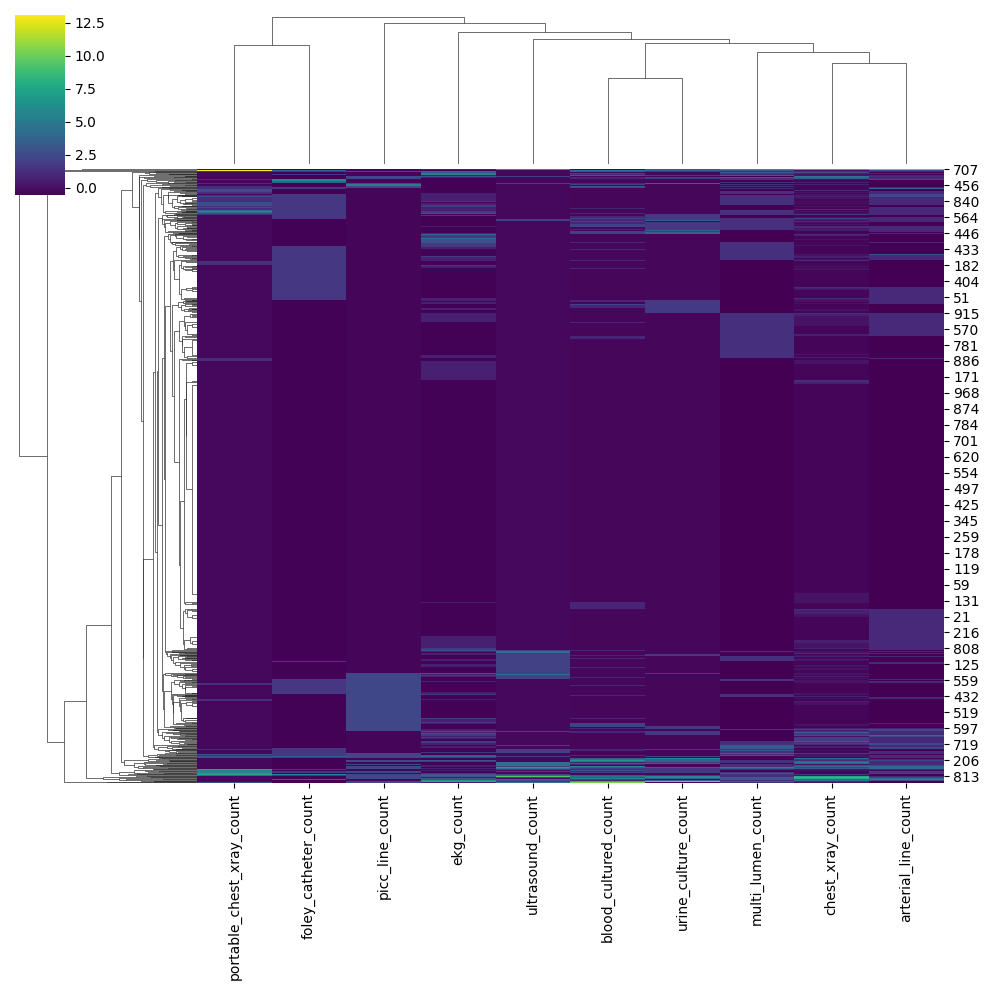

In [11]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


# Subsample to 5000 rows
sampled = heatmap_data.sample(n=1000, random_state=0)

# Scale
scaler = StandardScaler()
scaled = scaler.fit_transform(sampled)
scaled_df = pd.DataFrame(scaled, columns=sampled.columns)

# Heatmap
sns.clustermap(scaled_df, cmap="viridis", metric="euclidean")
plt.show()
